# LSTM Model

https://www.kaggle.com/vippatil/toxic-comment-using-lstm

In [2]:

import re
import nltk
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split

In [3]:
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install --user --upgrade tensorflow-gpu

In [37]:
t = pd.read_csv('test_labels.csv')

In [39]:
t['toxic'].value_counts()

-1    89186
 0    57888
 1     6090
Name: toxic, dtype: int64

In [4]:
comments_df = pd.read_csv("train.csv")

In [6]:
print(comments_df['toxic'].value_counts())
print(comments_df['severe_toxic'].value_counts())
print(comments_df['obscene'].value_counts())
print(comments_df['threat'].value_counts())
print(comments_df['insult'].value_counts())
print(comments_df['identity_hate'].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [7]:
train = pd.read_csv("./train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("./test.csv", encoding = "ISO-8859-1")

In [8]:
train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)

In [10]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [11]:
tokenizer = Tokenizer(num_words = 30000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

In [12]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments


Text(0.5, 0, 'Labels')

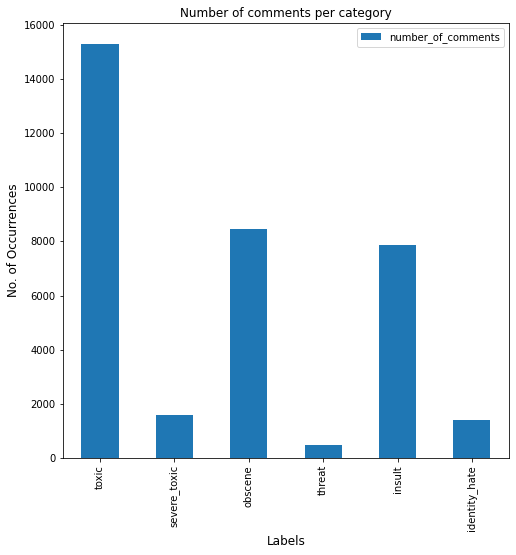

In [13]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments



,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


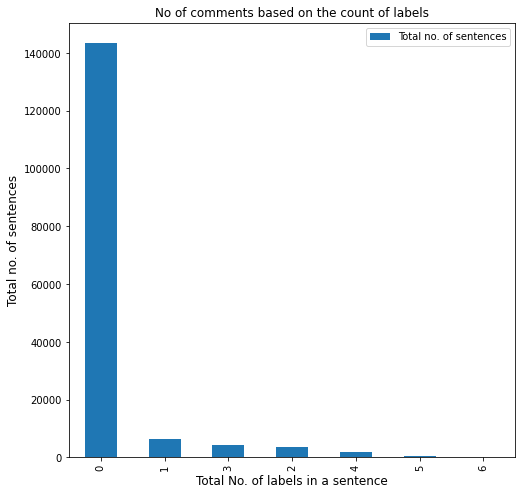

In [14]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.



c:\python\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\python\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\python\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\python\deeplearning\lib\site-packages

<AxesSubplot:xlabel='severe_toxic', ylabel='count'>

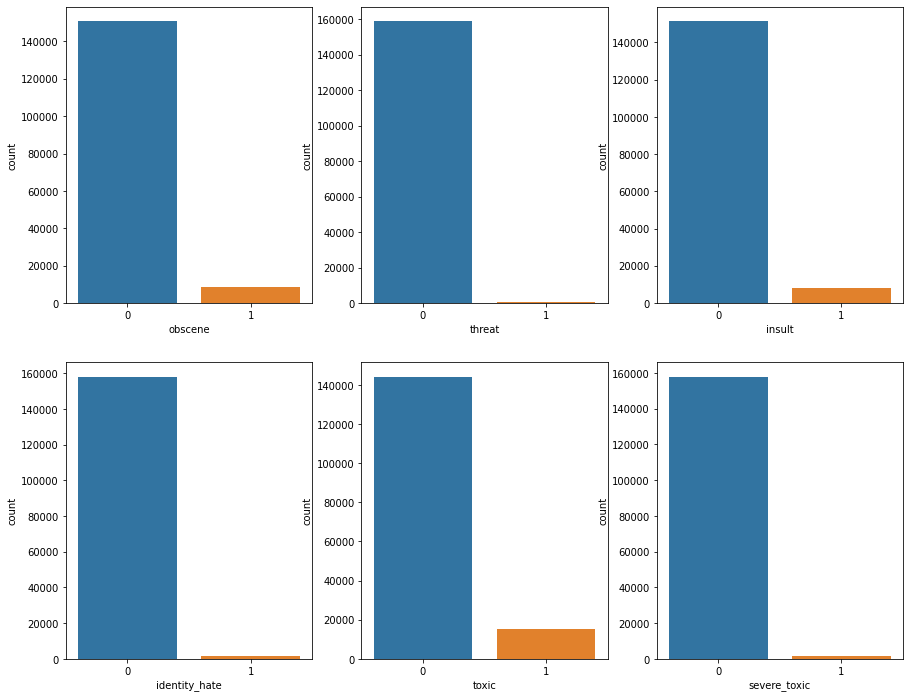

In [15]:
### Visualization 3

### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)


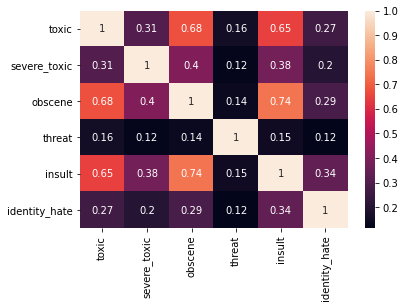

In [16]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [17]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 


In [18]:
## Data cleaning/Preparation 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)

In [19]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

In [20]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [21]:
### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_final, maxlen=150)
test_padded =pad_sequences(test_final, maxlen=150)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)

Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [22]:


### Building a model
### I have built a sequential model using LSTM. Initial layer contains a word embedding layer having 128 hidden units. 
### Input to the LSTM model is given in the shape of an array of (159571, 150). There are 6 main classes and every class is having 2 sub classes.
### For every Input observation, there are 6 labels. 
### I have used 2 LSTM layer with 64 hidden units. 1 Dense layer which is an output layer. Dropout probability is set to 0.2 for
### 2 lSTM layers which will dropout the 20 percent of neuron automatically while training.Dropout resolves the problem of overfitting. 
### Output layer contains 6 hidden units. I have used sigmoid activation function in the output layer. The reason behind using
### sigmoid activation function in the output layer is because we have multi label classification problem.
### Every class(label) is having 2 more classes i.e.0 and 1 to predict. 

model = Sequential()
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         5120000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 5,202,822
Trainable params: 5,202,822
Non-trainable params: 0
_________________________________________________________________


In [23]:
### Compiling the model and training the model using training dataset
### We need to define loss function to measure the loss. Our problem is multi label multi classification problem.
### Hence I decided to take loss function as binary_crossentropy. (Reference - https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)
### Adam optimizer is best for this problem. I tried RMSprop also but didn't get good accuracy. So decided to go with adam optimizer
### accuracy metric has been used. Dataset is divided into training and validation set. 
### We got an accuracy of 97.79% on validation dataset. batch_size is 32 . 
### These are the Number of samples that goes through the network at a time and calculates the loss by updating the parameters.
### I used only 1 epoch because I got almost 97% accuracy in 1 iteration.
### Submission from the competition was evaluated on the basis of AUC. Hence i decided to use AUC metrics.
### AUC is area under the curve. It can be calculated from receiver operating curve

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 1545s 413ms/step - loss: 0.0700 - auc: 0.9594 - val_loss: 0.0478 - val_auc: 0.9802


In [24]:
### Prediction for test data
predict = model.predict(test_padded)

In [32]:
predict[0]

array([0.9850299 , 0.44972908, 0.96345645, 0.047234  , 0.8786942 ,
       0.15024015], dtype=float32)

In [27]:
print("Predicted values are",predict)

Predicted values are [[9.85029876e-01 4.49729085e-01 9.63456452e-01 4.72339988e-02
  8.78694177e-01 1.50240153e-01]
 [4.06274199e-03 8.11106074e-05 3.34352255e-04 2.02625990e-04
  7.18593597e-04 3.92228365e-04]
 [2.61941552e-02 2.62171030e-04 2.13441253e-03 5.49763441e-04
  4.56944108e-03 1.79666281e-03]
 ...
 [2.32303143e-03 3.36210323e-05 1.80363655e-04 1.28269196e-04
  3.51697206e-04 2.96711922e-04]
 [2.88563967e-03 4.26901424e-05 2.42888927e-04 1.51544809e-04
  4.50700521e-04 3.69757414e-04]
 [9.75644767e-01 1.21076524e-01 8.90810966e-01 2.52958536e-02
  7.35308707e-01 1.02528542e-01]]


In [32]:
## predicted probabilities of each id in the test set, for all the target columns

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.973707,0.135356,0.832040,0.050744,0.610941,0.101365
1,0000247867823ef7,0.002784,0.000037,0.000259,0.000293,0.000689,0.000185
2,00013b17ad220c46,0.016355,0.000153,0.001298,0.001381,0.004152,0.000991
3,00017563c3f7919a,0.001541,0.000025,0.000168,0.000168,0.000392,0.000110
4,00017695ad8997eb,0.004929,0.000061,0.000446,0.000530,0.001303,0.000331


In [26]:
#### Complete description of classification system using neural networks

## This classification system is built using LSTM which is a special type of RNN's. I have used Keras library to build neural network.
## Recurrent Neural networks are used mostly for sequential data. We have sequential data(sentences). RNN's store information in their "memory".
## Recurrent Neural networks stores the information about the computations which has already been performed.
## Variety of RNN achitectures are available based on the need of the user. I have used LSTM which is a special type of RNN.
## Even though RNN are good for sequence modelling, it still have issues and it tends to have vanishing gradient problem.
## Vanishing gradient problem is faced by neural networks which uses activation function having small gradient(0 to 1).
## During backpropagation phase, these gradients either tend to become 0 or they vanishes. This happens because RNN's are not
## capable of handling long-term dependencies. In order to avoid vanishing gradient problem LSTM are developed. 
## LSTM comes with LSTM cell. It helps to model and keep track of long term dependencies. 

### Process performed in this classification model are mentioned below.
## Reading the dataset using pandas dataframe and checking whether it contains any null observations or not. There are no nulls in this dataset.
## Many people clean the data first and then perform visualizations. I performed visualizations first. 
## I created 4 visualizations. 
## 1st visualization is a Bar graph of total number of comments per label. It is helpful in identifying the total number of comments per label
## 2nd visualization is a Bar graph of Total No. of labels in a sentence against Total no. of sentences. 
## From 2nd visualization we can observe whether a sentence belongs to only one category or many categories. We can say that
## there are many sentences which are not classified(label 0) but many sentences falls under more than 1 category.
## 3rd Visualization is a Graph of individual class against the total no. of labelled and unlabelled sentences for the same class. 
## 4th Visualization is a Correlation graph(matrix) between different variables

## From visualization we can conclude that,  1) A single sentence can have multiple labels (categories).
## 2) Some labels are highely correlated to each other.
## 3) This is multi label classification problem. Hence we can use sigmoid function in the output layer.

### Next part includes cleaning the data. Data cleaning part is performed on the input text. 
## I created a function, which performs below activities: 
## 1) conversion of contraction words to expanded words , 2) removing stopwords , 3) lowercasing the words
## 4) removing the non - alphanumeric characters   5) removing the extra spaces between words

### Once we have cleaned the data, next part is creating input feature vectors.  
## Tokenizer class from keras library is used. 40000 words has been selected based on the frequency of the words and assigned a number using keras tokenizer
## Training dataset consists of sentences. Every sentence is made up of words. The number given to the words by the keras 
## tokenizer are used to build up a sentence. Padding is used to fix the sentence length to 150 words per sentence. 


### Input features are generated. Now its time to build a model. Model contains an Input embedding layer of 128 Hidden units.
## Models contains 2 LSTM layers of 64 Hidden units and 1 output layer of 6 Hiddent units having sigmoid activation function.
##Input to the neural network is given in the shape of (159571, 150).

### Next part is compiling the model and training it on training dataset. Training dataset is divided in training and validation dataset
##  Binary_crossentropy is used as a loss function. Adam optimizer is used. Accuracy metric has been used.
## batch_size is 32 . These are the Number of samples that goes through the network at a time and calculates the loss by
## updating the parameters.I used only 1 epoch because I got almost 97% accuracy in 1 iteration.